In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# EDA

Cчитаем датасеты и на время объединим их, чтобы было удобнее смотреть на EDA

In [15]:
tr = pd.read_csv("tr_for_students.csv")
vl = pd.read_csv("vl_for_students.csv")
tr = pd.concat([tr, vl], keys = ['train', 'test'])
tr

issue_d             purpose addr_state sub_grade  \
train 0      2012-01-01  debt_consolidation         IL        C3   
      1      2013-01-01  debt_consolidation         FL        B4   
      2      2013-07-01  debt_consolidation         NJ        B5   
      3      2014-03-01  debt_consolidation         MI        C2   
      4      2013-10-01         credit_card         TX        D2   
...                 ...                 ...        ...       ...   
test  60328  2014-10-01              moving         WV        E2   
      60329  2014-07-01         credit_card         VA        B5   
      60330  2014-09-01  debt_consolidation         WI        C3   
      60331  2015-04-01  debt_consolidation         CA        B3   
      60332  2015-01-01  debt_consolidation         AL        B5   

            home_ownership                    emp_title  installment    dti  \
train 0               RENT  Chicago Shakespeare Theatre       172.48  16.39   
      1           MORTGAGE               Queen of Pawns       674.94  16.31   
      2               RENT                 tek services       809.24  14.01   
      3           MORTGAGE            Inventory Control       342.56  14.51   
      4           MORTGAGE             Business Analyst       473.58  22.65   
...                    ...                          ...          ...    ...   
test  60328            OWN            Software Engineer        92.30  14.60   
      60329           RENT       Associate test manager      1070.37  13.60   
      60330            OWN          Executive Assistant       273.35  18.32   
      60331       MORTGAGE                   Parts tech       318.64  17.74   
      60332       MORTGAGE                      Manager      1162.34  18.18   

             funded_amnt  annual_inc  ...  mths_since_recent_inq  delinq_2yrs  \
train 0             5000     21600.0  ...                    NaN            0   
      1            20000     95000.0  ...                    4.0            0   
      2            24000     90000.0  ...                   19.0            0   
      3            10000     43000.0  ...                    5.0            1   
      4            13000     62000.0  ...                    5.0            0   
...                  ...         ...  ...                    ...          ...   
test  60328         2500     94500.0  ...                    3.0            0   
      60329        32000    110000.0  ...                   12.0            0   
      60330         8000     52000.0  ...                    6.0            0   
      60331        15000     52000.0  ...                    0.0            0   
      60332        35000    131200.0  ...                    1.0            0   

             chargeoff_within_12_mths  num_accts_ever_120_pd  \
train 0                             0                    NaN   
      1                             0                    0.0   
      2                             0                    0.0   
      3                             1                    4.0   
      4                             0                    0.0   
...                               ...                    ...   
test  60328                         0                    0.0   
      60329                         0                    0.0   
      60330                         0                    0.0   
      60331                         0                    0.0   
      60332                         0                    0.0   

             num_tl_90g_dpd_24m  acc_open_past_24mths  avg_cur_bal  \
train 0                     NaN                   NaN          NaN   
      1                     0.0                   4.0      23735.0   
      2                     0.0                   5.0       4070.0   
      3                     1.0                   3.0       1127.0   
      4                     0.0                   5.0       3443.0   
...                         ...                   ...          ...   
test  60328       

Посмотрим на распределение целевой переменной, а потом поработаем с пропусками

In [16]:
pie_df = pd.DataFrame(tr['def'].value_counts(normalize=True))
pie_df.reset_index(inplace=True)
pie_df['def'] = round(pie_df['def'], 2)
fig = px.pie(pie_df, values='def', names='index', color='index', color_discrete_map={1: '#9467BD', 0: '#FECB52'}, title='Non-Default (0) vs Default (1) Distribution')
fig.show()

Отметим, что распределение таргета не равномерно. Будем использовать эту информацию при разделении выборки на train и test

Теперь посмотрим на пропуски в данных

In [17]:
tr.isnull().sum()

issue_d                         0
purpose                         0
addr_state                      0
sub_grade                       0
home_ownership                  0
emp_title                    7011
installment                     0
dti                             0
funded_amnt                     0
annual_inc                      0
emp_length                   5809
term                            0
inq_last_6mths                  0
mths_since_recent_inq       19518
delinq_2yrs                     0
chargeoff_within_12_mths        0
num_accts_ever_120_pd       11941
num_tl_90g_dpd_24m          11941
acc_open_past_24mths         7886
avg_cur_bal                 11945
tot_hi_cred_lim             11941
delinq_amnt                     0
def                             0
dtype: int64

Видим, что колонки с количеством аккаунтов с задолженностями (>120 дней, >90 дней за последние 2 года), лимитом по кредиту и средним балансом по аккаунтам имеют практически одинаковое количество пропущенных значений. Проверим, одинаковые ли это строки

In [18]:
tr[tr['num_accts_ever_120_pd'].isnull()].isnull().sum()

issue_d                         0
purpose                         0
addr_state                      0
sub_grade                       0
home_ownership                  0
emp_title                     725
installment                     0
dti                             0
funded_amnt                     0
annual_inc                      0
emp_length                    414
term                            0
inq_last_6mths                  0
mths_since_recent_inq        8415
delinq_2yrs                     0
chargeoff_within_12_mths        0
num_accts_ever_120_pd       11941
num_tl_90g_dpd_24m          11941
acc_open_past_24mths         7886
avg_cur_bal                 11941
tot_hi_cred_lim             11941
delinq_amnt                     0
def                             0
dtype: int64

Видим, что это одни и те же люди. Возможно, это означает, что у человека до этого времени не было кредитов, поэтому данные недоступны. Заполним эти значения нулями и создадим колонку, которая будет говорить, было это значение заполнено или нет (0 – в колонках num_accts_ever_120_pd, num_tl_90g_dpd_24m, tot_hi_cred_lim не было NaN, 1 – был)

In [19]:
null_num_accts_ever_120_pd = tr[tr['num_accts_ever_120_pd'].isnull()].index

tr.loc[null_num_accts_ever_120_pd, 'num_accts_ever_120_pd'] = 0
tr.loc[null_num_accts_ever_120_pd, 'num_tl_90g_dpd_24m'] = 0
tr.loc[null_num_accts_ever_120_pd, 'avg_cur_bal'] = 0
tr.loc[null_num_accts_ever_120_pd, 'tot_hi_cred_lim'] = 0

tr.loc[null_num_accts_ever_120_pd, 'acc_open_past_24mths'] = 0

tr

issue_d             purpose addr_state sub_grade  \
train 0      2012-01-01  debt_consolidation         IL        C3   
      1      2013-01-01  debt_consolidation         FL        B4   
      2      2013-07-01  debt_consolidation         NJ        B5   
      3      2014-03-01  debt_consolidation         MI        C2   
      4      2013-10-01         credit_card         TX        D2   
...                 ...                 ...        ...       ...   
test  60328  2014-10-01              moving         WV        E2   
      60329  2014-07-01         credit_card         VA        B5   
      60330  2014-09-01  debt_consolidation         WI        C3   
      60331  2015-04-01  debt_consolidation         CA        B3   
      60332  2015-01-01  debt_consolidation         AL        B5   

            home_ownership                    emp_title  installment    dti  \
train 0               RENT  Chicago Shakespeare Theatre       172.48  16.39   
      1           MORTGAGE               Queen of Pawns       674.94  16.31   
      2               RENT                 tek services       809.24  14.01   
      3           MORTGAGE            Inventory Control       342.56  14.51   
      4           MORTGAGE             Business Analyst       473.58  22.65   
...                    ...                          ...          ...    ...   
test  60328            OWN            Software Engineer        92.30  14.60   
      60329           RENT       Associate test manager      1070.37  13.60   
      60330            OWN          Executive Assistant       273.35  18.32   
      60331       MORTGAGE                   Parts tech       318.64  17.74   
      60332       MORTGAGE                      Manager      1162.34  18.18   

             funded_amnt  annual_inc  ...  mths_since_recent_inq  delinq_2yrs  \
train 0             5000     21600.0  ...                    NaN            0   
      1            20000     95000.0  ...                    4.0            0   
      2            24000     90000.0  ...                   19.0            0   
      3            10000     43000.0  ...                    5.0            1   
      4            13000     62000.0  ...                    5.0            0   
...                  ...         ...  ...                    ...          ...   
test  60328         2500     94500.0  ...                    3.0            0   
      60329        32000    110000.0  ...                   12.0            0   
      60330         8000     52000.0  ...                    6.0            0   
      60331        15000     52000.0  ...                    0.0            0   
      60332        35000    131200.0  ...                    1.0            0   

             chargeoff_within_12_mths  num_accts_ever_120_pd  \
train 0                             0                    0.0   
      1                             0                    0.0   
      2                             0                    0.0   
      3                             1                    4.0   
      4                             0                    0.0   
...                               ...                    ...   
test  60328                         0                    0.0   
      60329                         0                    0.0   
      60330                         0                    0.0   
      60331                         0                    0.0   
      60332                         0                    0.0   

             num_tl_90g_dpd_24m  acc_open_past_24mths  avg_cur_bal  \
train 0                     0.0                   0.0          0.0   
      1                     0.0                   4.0      23735.0   
      2                     0.0                   5.0       4070.0   
      3                     1.0                   3.0       1127.0   
      4                     0.0                   5.0       3443.0   
...                         ...                   ...          ...   
test  60328       

Если нет запросов на кредиты за последние 6 месяцев и неизвестно время с последнего запроса, будем считать, что человек не делал запросов совсем (но сохраним информацию об этом в доп. колонку)

In [20]:
tr['mths_since_recent_inq'].value_counts()

1.0     11480
0.0      9277
2.0      8877
3.0      8006
4.0      7356
5.0      6648
6.0      5982
7.0      5869
8.0      5105
9.0      4506
10.0     3920
11.0     3384
12.0     3210
13.0     2764
14.0     2439
15.0     2133
16.0     1871
17.0     1648
18.0     1487
19.0     1327
20.0     1211
21.0     1104
22.0      998
23.0      928
24.0      453
25.0        1
Name: mths_since_recent_inq, dtype: int64

In [21]:
tr.loc[null_num_accts_ever_120_pd, 'mths_since_recent_inq'] = 0
tr['mths_since_recent_inq'].value_counts()

0.0     20836
1.0     11022
2.0      8528
3.0      7748
4.0      7134
5.0      6469
6.0      5798
7.0      5679
8.0      4912
9.0      4361
10.0     3791
11.0     3270
12.0     3103
13.0     2667
14.0     2353
15.0     2069
16.0     1821
17.0     1587
18.0     1442
19.0     1279
20.0     1170
21.0     1074
22.0      957
23.0      894
24.0      434
25.0        1
Name: mths_since_recent_inq, dtype: int64

In [22]:
tr.isnull().sum()

issue_d                         0
purpose                         0
addr_state                      0
sub_grade                       0
home_ownership                  0
emp_title                    7011
installment                     0
dti                             0
funded_amnt                     0
annual_inc                      0
emp_length                   5809
term                            0
inq_last_6mths                  0
mths_since_recent_inq       11103
delinq_2yrs                     0
chargeoff_within_12_mths        0
num_accts_ever_120_pd           0
num_tl_90g_dpd_24m              0
acc_open_past_24mths            0
avg_cur_bal                     4
tot_hi_cred_lim                 0
delinq_amnt                     0
def                             0
dtype: int64

Оставшиеся неизвестные значения о количестве месяцев заменим медианой

In [23]:
tr.loc[tr[tr['mths_since_recent_inq'].isnull()].index, 'mths_since_recent_inq'] = tr[tr['mths_since_recent_inq'].isnull() == False]['mths_since_recent_inq'].median()

Там, где очень мало значений, отличных от нуля, объединим их в одну группу "не ноль"

In [24]:
tr['delinq_2yrs'] = tr['delinq_2yrs'].apply(lambda x : x if x == 0 else 1)
tr['chargeoff_within_12_mths'] = tr['chargeoff_within_12_mths'].apply(lambda x : x if x == 0 else 1)
tr['num_accts_ever_120_pd'] = tr['num_accts_ever_120_pd'].apply(lambda x : x if x == 0 else 1)
tr['num_tl_90g_dpd_24m'] = tr['num_tl_90g_dpd_24m'].apply(lambda x : x if x == 0 else 1)
tr['delinq_amnt'] = tr['delinq_amnt'].apply(lambda x : x if x == 0 else 1)

Поработаем с названием должности

In [25]:
tr['employment_known'] = tr['emp_title'].apply(lambda x: 0 if pd.isna(x) else 1)
tr.loc[tr[tr['emp_title'].isnull()].index, 'emp_title'] = 'Unknown'
tr['emp_title_length'] = tr['emp_title'].apply(lambda x: len(x) if x != 'Unknown' else 0)
tr

issue_d             purpose addr_state sub_grade  \
train 0      2012-01-01  debt_consolidation         IL        C3   
      1      2013-01-01  debt_consolidation         FL        B4   
      2      2013-07-01  debt_consolidation         NJ        B5   
      3      2014-03-01  debt_consolidation         MI        C2   
      4      2013-10-01         credit_card         TX        D2   
...                 ...                 ...        ...       ...   
test  60328  2014-10-01              moving         WV        E2   
      60329  2014-07-01         credit_card         VA        B5   
      60330  2014-09-01  debt_consolidation         WI        C3   
      60331  2015-04-01  debt_consolidation         CA        B3   
      60332  2015-01-01  debt_consolidation         AL        B5   

            home_ownership                    emp_title  installment    dti  \
train 0               RENT  Chicago Shakespeare Theatre       172.48  16.39   
      1           MORTGAGE               Queen of Pawns       674.94  16.31   
      2               RENT                 tek services       809.24  14.01   
      3           MORTGAGE            Inventory Control       342.56  14.51   
      4           MORTGAGE             Business Analyst       473.58  22.65   
...                    ...                          ...          ...    ...   
test  60328            OWN            Software Engineer        92.30  14.60   
      60329           RENT       Associate test manager      1070.37  13.60   
      60330            OWN          Executive Assistant       273.35  18.32   
      60331       MORTGAGE                   Parts tech       318.64  17.74   
      60332       MORTGAGE                      Manager      1162.34  18.18   

             funded_amnt  annual_inc  ...  chargeoff_within_12_mths  \
train 0             5000     21600.0  ...                         0   
      1            20000     95000.0  ...                         0   
      2            24000     90000.0  ...                         0   
      3            10000     43000.0  ...                         1   
      4            13000     62000.0  ...                         0   
...                  ...         ...  ...                       ...   
test  60328         2500     94500.0  ...                         0   
      60329        32000    110000.0  ...                         0   
      60330         8000     52000.0  ...                         0   
      60331        15000     52000.0  ...                         0   
      60332        35000    131200.0  ...                         0   

             num_accts_ever_120_pd  num_tl_90g_dpd_24m  acc_open_past_24mths  \
train 0                        0.0                 0.0                   0.0   
      1                        0.0                 0.0                   4.0   
      2                        0.0                 0.0                   5.0   
      3                        1.0                 1.0                   3.0   
      4                        0.0                 0.0                   5.0   
...                            ...                 ...                   ...   
test  60328                    0.0                 0.0                  11.0   
      60329                    0.0                 0.0                   2.0   
      60330                    0.0                 0.0                   6.0   
      60331                    0.0                 0.0                   4.0   
      60332                    0.0                 0.0                   9.0   

             avg_cur_bal  tot_hi_cred_lim  delinq_amnt  def  employment_known  \
train 0              0.0              0.0            0    0                 1   
      1          23735.0         153379.0            0    0                 1   
      2           4070.0          50834.0            0    0                 1   
      3           1127.0          32683.0            0    0                 1   
      4           3443.0       

In [26]:
tr.loc[tr[tr['emp_length'].isnull()].index, 'emp_length'] = tr[tr['emp_length'].isnull() == False]['emp_length'].median()

In [27]:
tr.isnull().sum()

issue_d                     0
purpose                     0
addr_state                  0
sub_grade                   0
home_ownership              0
emp_title                   0
installment                 0
dti                         0
funded_amnt                 0
annual_inc                  0
emp_length                  0
term                        0
inq_last_6mths              0
mths_since_recent_inq       0
delinq_2yrs                 0
chargeoff_within_12_mths    0
num_accts_ever_120_pd       0
num_tl_90g_dpd_24m          0
acc_open_past_24mths        0
avg_cur_bal                 4
tot_hi_cred_lim             0
delinq_amnt                 0
def                         0
employment_known            0
emp_title_length            0
dtype: int64

avg_cur_bal заменим медианным значением (не так критично, потому что неизвестных значений всего 4 из >60000)

In [28]:
tr.loc[tr[tr['avg_cur_bal'].isnull()].index, 'avg_cur_bal'] = tr[tr['avg_cur_bal'].isnull() == False]['avg_cur_bal'].median()
tr

issue_d             purpose addr_state sub_grade  \
train 0      2012-01-01  debt_consolidation         IL        C3   
      1      2013-01-01  debt_consolidation         FL        B4   
      2      2013-07-01  debt_consolidation         NJ        B5   
      3      2014-03-01  debt_consolidation         MI        C2   
      4      2013-10-01         credit_card         TX        D2   
...                 ...                 ...        ...       ...   
test  60328  2014-10-01              moving         WV        E2   
      60329  2014-07-01         credit_card         VA        B5   
      60330  2014-09-01  debt_consolidation         WI        C3   
      60331  2015-04-01  debt_consolidation         CA        B3   
      60332  2015-01-01  debt_consolidation         AL        B5   

            home_ownership                    emp_title  installment    dti  \
train 0               RENT  Chicago Shakespeare Theatre       172.48  16.39   
      1           MORTGAGE               Queen of Pawns       674.94  16.31   
      2               RENT                 tek services       809.24  14.01   
      3           MORTGAGE            Inventory Control       342.56  14.51   
      4           MORTGAGE             Business Analyst       473.58  22.65   
...                    ...                          ...          ...    ...   
test  60328            OWN            Software Engineer        92.30  14.60   
      60329           RENT       Associate test manager      1070.37  13.60   
      60330            OWN          Executive Assistant       273.35  18.32   
      60331       MORTGAGE                   Parts tech       318.64  17.74   
      60332       MORTGAGE                      Manager      1162.34  18.18   

             funded_amnt  annual_inc  ...  chargeoff_within_12_mths  \
train 0             5000     21600.0  ...                         0   
      1            20000     95000.0  ...                         0   
      2            24000     90000.0  ...                         0   
      3            10000     43000.0  ...                         1   
      4            13000     62000.0  ...                         0   
...                  ...         ...  ...                       ...   
test  60328         2500     94500.0  ...                         0   
      60329        32000    110000.0  ...                         0   
      60330         8000     52000.0  ...                         0   
      60331        15000     52000.0  ...                         0   
      60332        35000    131200.0  ...                         0   

             num_accts_ever_120_pd  num_tl_90g_dpd_24m  acc_open_past_24mths  \
train 0                        0.0                 0.0                   0.0   
      1                        0.0                 0.0                   4.0   
      2                        0.0                 0.0                   5.0   
      3                        1.0                 1.0                   3.0   
      4                        0.0                 0.0                   5.0   
...                            ...                 ...                   ...   
test  60328                    0.0                 0.0                  11.0   
      60329                    0.0                 0.0                   2.0   
      60330                    0.0                 0.0                   6.0   
      60331                    0.0                 0.0                   4.0   
      60332                    0.0                 0.0                   9.0   

             avg_cur_bal  tot_hi_cred_lim  delinq_amnt  def  employment_known  \
train 0              0.0              0.0            0    0                 1   
      1          23735.0         153379.0            0    0                 1   
      2           4070.0          50834.0            0    0                 1   
      3           1127.0          32683.0            0    0                 1   
      4           3443.0       

Теперь создадим несколько новых признаков. Начнем с разбиения даты (issue_d) на год, месяц и день недели

In [29]:
dates = tr['issue_d'].astype(np.datetime64)
tr['issue_year'] = dates.apply(lambda x: x.year)
tr['issue_month'] = dates.apply(lambda x: x.month)
# признак число месяца не нужен, как и день недели – везде просто 1 число, а не реальная дата
tr = tr.drop(columns='issue_d', axis = 1)
tr

purpose addr_state sub_grade home_ownership  \
train 0      debt_consolidation         IL        C3           RENT   
      1      debt_consolidation         FL        B4       MORTGAGE   
      2      debt_consolidation         NJ        B5           RENT   
      3      debt_consolidation         MI        C2       MORTGAGE   
      4             credit_card         TX        D2       MORTGAGE   
...                         ...        ...       ...            ...   
test  60328              moving         WV        E2            OWN   
      60329         credit_card         VA        B5           RENT   
      60330  debt_consolidation         WI        C3            OWN   
      60331  debt_consolidation         CA        B3       MORTGAGE   
      60332  debt_consolidation         AL        B5       MORTGAGE   

                               emp_title  installment    dti  funded_amnt  \
train 0      Chicago Shakespeare Theatre       172.48  16.39         5000   
      1                   Queen of Pawns       674.94  16.31        20000   
      2                     tek services       809.24  14.01        24000   
      3                Inventory Control       342.56  14.51        10000   
      4                 Business Analyst       473.58  22.65        13000   
...                                  ...          ...    ...          ...   
test  60328            Software Engineer        92.30  14.60         2500   
      60329       Associate test manager      1070.37  13.60        32000   
      60330          Executive Assistant       273.35  18.32         8000   
      60331                   Parts tech       318.64  17.74        15000   
      60332                      Manager      1162.34  18.18        35000   

             annual_inc  emp_length  ...  num_tl_90g_dpd_24m  \
train 0         21600.0         0.0  ...                 0.0   
      1         95000.0        10.0  ...                 0.0   
      2         90000.0         3.0  ...                 0.0   
      3         43000.0        10.0  ...                 1.0   
      4         62000.0         1.0  ...                 0.0   
...                 ...         ...  ...                 ...   
test  60328     94500.0         6.0  ...                 0.0   
      60329    110000.0         0.0  ...                 0.0   
      60330     52000.0        10.0  ...                 0.0   
      60331     52000.0         3.0  ...                 0.0   
      60332    131200.0         1.0  ...                 0.0   

             acc_open_past_24mths  avg_cur_bal  tot_hi_cred_lim  delinq_amnt  \
train 0                       0.0          0.0              0.0            0   
      1                       4.0      23735.0         153379.0            0   
      2                       5.0       4070.0          50834.0            0   
      3                       3.0       1127.0          32683.0            0   
      4                       5.0       3443.0          59495.0            0   
...                           ...          ...              ...          ...   
test  60328                  11.0      18053.0         391249.0            0   
      60329                   2.0       4840.0          64200.0            0   
      60330                   6.0      23024.0         223121.0            0   
      60331                   4.0      22523.0         304634.0            0   
      60332                   9.0       6546.0         239358.0            0   

             def  employment_known  emp_title_length  issue_year  issue_month  
train 0        0                 1                27        2012            1  
      1        0                 1                14        2013            1  
      2        0                 1                12        2013            7  
      3        0                 1                17        2014            3  
      4        0                 1                16        2013           10  
...          ...               ...  

Далее посмотрим на распределения таргета в зависимости от значения sub_grade и созданного при помощи этой колонки значения признака grade (более общий). Для этого создадим функцию, которая будет рисовать нам красивое распределение таргета в зависимости от значений заданного признака, и назовем ее build_default_distribution(feature)

In [30]:
def build_default_distribution(feature):
    column_def = tr[tr['def'] == 1][feature].value_counts()
    column_non = tr[tr['def'] == 0][feature].value_counts()
    df = pd.DataFrame({'default' : column_def, 'non' : column_non})
    df['def_%'] = round(df['default'] / (df['default'] + df['non']), 2)
    df['non_%'] = round(df['non'] / (df['default'] + df['non']), 2)
    df = df.drop(columns = ['default', 'non'])
    df.reset_index(inplace=True)
    df = df.rename(columns = {'index' : feature})
    
    df1 = df.loc[df.index, [feature, 'def_%']]
    df1['class'] = ['default'] * len(df1)
    df1 = df1.rename(columns = {'def_%' : 'proportion'})
    
    df2 = df.loc[df.index, [feature, 'non_%']]
    df2['class'] = ['non-default'] * len(df2)
    df2 = df2.rename(columns = {'non_%' : 'proportion'})
    
    df_new = pd.concat([df1, df2])
    fig = px.bar(df_new, x=feature, y="proportion", color="class", color_discrete_map={'default': '#9467BD', 'non-default': '#FECB52'}, text_auto=True)
    fig.update_layout(title = "Default / Non-default Distribution by " + feature)
    fig.show()

In [31]:
tr['grade'] = tr['sub_grade'].apply(lambda x : x[0])
tr['grade'].value_counts()

B    34701
C    33407
A    19937
D    19764
E     9636
F     3244
G      813
Name: grade, dtype: int64

In [32]:
build_default_distribution("grade")
build_default_distribution("sub_grade")

Будем иметь в виду, что в будущем будет использоваться WOE-преобразование признаков, поэтому сохраним признак grade вместо sub_grade, так как по нему зависимость таргета видна более четко

Значений у колонки с штатом очень много, при этом не все они репрезентативны, так как соответствуют всего нескольким потенциальным заемщикам

In [33]:
tr['addr_state'].value_counts(normalize=True)

CA    0.148804
NY    0.083645
TX    0.078558
FL    0.067843
IL    0.039571
NJ    0.037687
PA    0.035185
OH    0.032938
GA    0.032329
VA    0.030279
NC    0.028790
MI    0.025860
MD    0.024222
MA    0.022938
AZ    0.022823
WA    0.022526
CO    0.021605
MN    0.017926
MO    0.016156
IN    0.015317
CT    0.015218
NV    0.014724
TN    0.013819
WI    0.013498
OR    0.013029
AL    0.012650
LA    0.011597
SC    0.011531
KY    0.009506
KS    0.008955
OK    0.008576
AR    0.007605
UT    0.007358
NM    0.005490
WV    0.005391
HI    0.005284
NH    0.004765
RI    0.004395
MS    0.003473
MT    0.003053
AK    0.002955
DE    0.002872
DC    0.002839
WY    0.002288
SD    0.002091
VT    0.002033
IA    0.000008
Name: addr_state, dtype: float64

In [34]:
freq_states = tr['addr_state'].value_counts(normalize=True)[:10]
tr['addr_state'] = tr['addr_state'].apply(lambda x: x if x in freq_states else 'Rare')

Посмотрим на описательные статистики

In [35]:
tr.describe()

installment            dti    funded_amnt    annual_inc  \
count  121502.000000  121502.000000  121502.000000  1.215020e+05   
mean      436.250343      17.756936   14597.043464  7.410526e+04   
std       243.356861       8.059351    8351.943362  6.126074e+04   
min         4.930000       0.000000    1000.000000  6.000000e+03   
25%       261.750000      11.740000    8000.000000  4.500000e+04   
50%       382.550000      17.350000   12750.000000  6.373400e+04   
75%       570.710000      23.390000   20000.000000  9.000000e+04   
max      1408.130000      39.990000   35000.000000  7.500000e+06   

          emp_length           term  inq_last_6mths  mths_since_recent_inq  \
count  121502.000000  121502.000000   121502.000000          121502.000000   
mean        6.036213      43.034156        0.735535               5.957499   
std         3.554166      10.924348        1.010732               5.731851   
min         0.000000      36.000000        0.000000               0.000000   
25%         3.000000      36.000000        0.000000               1.000000   
50%         6.000000      36.000000        0.000000               4.000000   
75%        10.000000      60.000000        1.000000               9.000000   
max        10.000000      60.000000        8.000000              25.000000   

         delinq_2yrs  chargeoff_within_12_mths  ...  num_tl_90g_dpd_24m  \
count  121502.000000             121502.000000  ...       121502.000000   
mean        0.185873                  0.007473  ...            0.051612   
std         0.389006                  0.086124  ...            0.221244   
min         0.000000                  0.000000  ...            0.000000   
25%         0.000000                  0.000000  ...            0.000000   
50%         0.000000                  0.000000  ...            0.000000   
75%         0.000000                  0.000000  ...            0.000000   
max         1.000000                  1.000000  ...            1.000000   

       acc_open_past_24mths    avg_cur_bal  tot_hi_cred_lim    delinq_amnt  \
count         121502.000000  121502.000000     1.215020e+05  121502.000000   
mean               3.890594   12069.868241     1.523699e+05       0.003185   
std                3.026160   15528.612686     1.696062e+05       0.056347   
min                0.000000       0.000000     0.000000e+00       0.000000   
25%                2.000000    2294.000000     3.576050e+04       0.000000   
50%                3.000000    5987.000000     8.889500e+04       0.000000   
75%                6.000000   17209.500000     2.296952e+05       0.000000   
max               37.000000  358652.000000     9.999999e+06       1.000000   

                 def  employment_known  emp_title_length     issue_year  \
count  121502.000000     121502.000000     121502.000000  121502.000000   
mean        0.168104          0.942297         15.397450    2013.677709   
std         0.373960          0.233181          8.637517       1.143545   
min         0.000000          0.000000          0.000000    2010.000000   
25%         0.000000          1.000000          9.000000    2013.000000   
50%         0.000000          1.000000         15.000000    2014.000000   
75%         0.000000          1.000000         21.000000    2014.000000   
max         1.000000          1.000000         64.000000    2015.000000   

         issue_month  
count  121502.000000  
mean        6.083727  
std         3.438666  
min         1.000000  
25%         3.000000  
50%         6.000000  
75%         9.000000  
max        12.000000  

[8 rows x 21 columns]

Теперь удалим ненужные колонки и заменим некоторые из них на признаки-индикаторы (удалим один из них в каждой категории, чтобы не было линейной зависимости)

In [36]:
tr = tr.drop(columns = ['sub_grade', 'emp_title'])

In [37]:
tr

purpose addr_state home_ownership  installment    dti  \
train 0      debt_consolidation         IL           RENT       172.48  16.39   
      1      debt_consolidation         FL       MORTGAGE       674.94  16.31   
      2      debt_consolidation         NJ           RENT       809.24  14.01   
      3      debt_consolidation       Rare       MORTGAGE       342.56  14.51   
      4             credit_card         TX       MORTGAGE       473.58  22.65   
...                         ...        ...            ...          ...    ...   
test  60328              moving       Rare            OWN        92.30  14.60   
      60329         credit_card         VA           RENT      1070.37  13.60   
      60330  debt_consolidation       Rare            OWN       273.35  18.32   
      60331  debt_consolidation         CA       MORTGAGE       318.64  17.74   
      60332  debt_consolidation       Rare       MORTGAGE      1162.34  18.18   

             funded_amnt  annual_inc  emp_length  term  inq_last_6mths  ...  \
train 0             5000     21600.0         0.0    36               3  ...   
      1            20000     95000.0        10.0    36               1  ...   
      2            24000     90000.0         3.0    36               0  ...   
      3            10000     43000.0        10.0    36               1  ...   
      4            13000     62000.0         1.0    36               3  ...   
...                  ...         ...         ...   ...             ...  ...   
test  60328         2500     94500.0         6.0    36               0  ...   
      60329        32000    110000.0         0.0    36               0  ...   
      60330         8000     52000.0        10.0    36               0  ...   
      60331        15000     52000.0         3.0    60               0  ...   
      60332        35000    131200.0         1.0    36               0  ...   

             acc_open_past_24mths  avg_cur_bal  tot_hi_cred_lim  delinq_amnt  \
train 0                       0.0          0.0              0.0            0   
      1                       4.0      23735.0         153379.0            0   
      2                       5.0       4070.0          50834.0            0   
      3                       3.0       1127.0          32683.0            0   
      4                       5.0       3443.0          59495.0            0   
...                           ...          ...              ...          ...   
test  60328                  11.0      18053.0         391249.0            0   
      60329                   2.0       4840.0          64200.0            0   
      60330                   6.0      23024.0         223121.0            0   
      60331                   4.0      22523.0         304634.0            0   
      60332                   9.0       6546.0         239358.0            0   

             def  employment_known  emp_title_length  issue_year  issue_month  \
train 0        0                 1                27        2012            1   
      1        0                 1                14        2013            1   
      2        0                 1                12        2013            7   
      3        0                 1                17        2014            3   
      4        0                 1                16        2013           10   
...          ...               ...               ...         ...          ...   
test  60328    0                 1                17        2014           10   
      60329    0                 1                22        2014            7   
      60330    0                 1                19        2014            9   
      60331    0                 1                10        2015            4   
      60332    1                 1                 7        2015            1   

             grade  
train 0          C  
      1          B  
      2          B  
      3          C  
      4          D  
...            ...  
test  60328      E  


In [38]:
tr['home_ownership'] = tr['home_ownership'].apply(lambda x: x if x != 'NONE' else 'OTHER')

In [39]:
tr

purpose addr_state home_ownership  installment    dti  \
train 0      debt_consolidation         IL           RENT       172.48  16.39   
      1      debt_consolidation         FL       MORTGAGE       674.94  16.31   
      2      debt_consolidation         NJ           RENT       809.24  14.01   
      3      debt_consolidation       Rare       MORTGAGE       342.56  14.51   
      4             credit_card         TX       MORTGAGE       473.58  22.65   
...                         ...        ...            ...          ...    ...   
test  60328              moving       Rare            OWN        92.30  14.60   
      60329         credit_card         VA           RENT      1070.37  13.60   
      60330  debt_consolidation       Rare            OWN       273.35  18.32   
      60331  debt_consolidation         CA       MORTGAGE       318.64  17.74   
      60332  debt_consolidation       Rare       MORTGAGE      1162.34  18.18   

             funded_amnt  annual_inc  emp_length  term  inq_last_6mths  ...  \
train 0             5000     21600.0         0.0    36               3  ...   
      1            20000     95000.0        10.0    36               1  ...   
      2            24000     90000.0         3.0    36               0  ...   
      3            10000     43000.0        10.0    36               1  ...   
      4            13000     62000.0         1.0    36               3  ...   
...                  ...         ...         ...   ...             ...  ...   
test  60328         2500     94500.0         6.0    36               0  ...   
      60329        32000    110000.0         0.0    36               0  ...   
      60330         8000     52000.0        10.0    36               0  ...   
      60331        15000     52000.0         3.0    60               0  ...   
      60332        35000    131200.0         1.0    36               0  ...   

             acc_open_past_24mths  avg_cur_bal  tot_hi_cred_lim  delinq_amnt  \
train 0                       0.0          0.0              0.0            0   
      1                       4.0      23735.0         153379.0            0   
      2                       5.0       4070.0          50834.0            0   
      3                       3.0       1127.0          32683.0            0   
      4                       5.0       3443.0          59495.0            0   
...                           ...          ...              ...          ...   
test  60328                  11.0      18053.0         391249.0            0   
      60329                   2.0       4840.0          64200.0            0   
      60330                   6.0      23024.0         223121.0            0   
      60331                   4.0      22523.0         304634.0            0   
      60332                   9.0       6546.0         239358.0            0   

             def  employment_known  emp_title_length  issue_year  issue_month  \
train 0        0                 1                27        2012            1   
      1        0                 1                14        2013            1   
      2        0                 1                12        2013            7   
      3        0                 1                17        2014            3   
      4        0                 1                16        2013           10   
...          ...               ...               ...         ...          ...   
test  60328    0                 1                17        2014           10   
      60329    0                 1                22        2014            7   
      60330    0                 1                19        2014            9   
      60331    0                 1                10        2015            4   
      60332    1                 1                 7        2015            1   

             grade  
train 0          C  
      1          B  
      2          B  
      3          C  
      4          D  
...            ...  
test  60328      E  


# WOE-трансформация

Разделим tr на train и test, как было ранее

In [40]:
tr_new = tr.loc['train']
test_new = tr.loc['test']
tr_new

purpose addr_state home_ownership  installment    dti  \
0      debt_consolidation         IL           RENT       172.48  16.39   
1      debt_consolidation         FL       MORTGAGE       674.94  16.31   
2      debt_consolidation         NJ           RENT       809.24  14.01   
3      debt_consolidation       Rare       MORTGAGE       342.56  14.51   
4             credit_card         TX       MORTGAGE       473.58  22.65   
...                   ...        ...            ...          ...    ...   
61164  debt_consolidation         CA           RENT       583.47   7.96   
61165  debt_consolidation         TX       MORTGAGE       341.72  20.97   
61166  debt_consolidation         FL           RENT       245.06  33.65   
61167  debt_consolidation         TX       MORTGAGE       107.73  18.48   
61168               other         IL           RENT        76.80  22.33   

       funded_amnt  annual_inc  emp_length  term  inq_last_6mths  ...  \
0             5000     21600.0         0.0    36               3  ...   
1            20000     95000.0        10.0    36               1  ...   
2            24000     90000.0         3.0    36               0  ...   
3            10000     43000.0        10.0    36               1  ...   
4            13000     62000.0         1.0    36               3  ...   
...            ...         ...         ...   ...             ...  ...   
61164        18375    133325.0         0.0    36               0  ...   
61165        16500     82000.0         9.0    60               2  ...   
61166         6800     27000.0        10.0    36               1  ...   
61167         3250     58000.0        10.0    36               0  ...   
61168         2000     28000.0        10.0    36               1  ...   

       acc_open_past_24mths  avg_cur_bal  tot_hi_cred_lim  delinq_amnt  def  \
0                       0.0          0.0              0.0            0    0   
1                       4.0      23735.0         153379.0            0    0   
2                       5.0       4070.0          50834.0            0    0   
3                       3.0       1127.0          32683.0            0    0   
4                       5.0       3443.0          59495.0            0    0   
...                     ...          ...              ...          ...  ...   
61164                   1.0       5278.0          48557.0            0    0   
61165                   3.0      18594.0         333493.0            0    0   
61166                   5.0       2093.0          36095.0            0    0   
61167                   0.0          0.0              0.0            0    0   
61168                   5.0       1302.0          17432.0            0    0   

       employment_known  emp_title_length  issue_year  issue_month  grade  
0                     1                27        2012            1      C  
1                     1                14        2013            1      B  
2                     1                12        2013            7      B  
3                     1                17        2014            3      C  
4                     1                16        2013           10      D  
...                 ...               ...         ...          ...    ...  
61164                 1                31        2013            2      A  
61165                 1                16        2013            7      A  
61166                 1                 6        2013            4      D  
61167                 1                 9        2010           10      B  
61168                 1                13        2013           10      E  

[61169 rows x 25 columns]

Теперь сделаем скоринговую карту: сначала посмотрим на woe, iv и графики с оптимальным разбиением, а потом построим регрессию и саму карту

In [41]:
# после неудачных попыток пофиксить зависимость на графиках woe до напоминающей линейную в признаках
# issue_year, issue_month, mths_since_recent_inq и emp_length было принято решение убрать эти признаки
tr_new = tr_new.drop(columns = ['issue_year', 'emp_length', 'issue_month', 'mths_since_recent_inq'])
test_new = test_new.drop(columns = ['issue_year', 'emp_length', 'issue_month', 'mths_since_recent_inq'])

In [42]:
tr_nowoe = tr_new[tr_new.columns[tr_new.isin([0, 1]).all()]].copy()
non_bin_names = set(tr_new.columns) - set(tr_new.columns[tr_new.isin([0, 1]).all()])
tr_woe = tr_new[non_bin_names.union({'def'})].copy()

test_woe = test_new[non_bin_names.union({'def'})].copy()

In [43]:
import scorecardpy as sc
bins = sc.woebin(tr_woe, y="def")

[INFO] creating woe binning ...


In [44]:
woe_iv_df = pd.concat(bins)
pd.set_option('display.max_rows', len(woe_iv_df))
woe_iv_df

variable  \
term                 0                  term   
                     1                  term   
purpose              0               purpose   
                     1               purpose   
                     2               purpose   
                     3               purpose   
annual_inc           0            annual_inc   
                     1            annual_inc   
                     2            annual_inc   
                     3            annual_inc   
grade                0                 grade   
                     1                 grade   
                     2                 grade   
                     3                 grade   
                     4                 grade   
dti                  0                   dti   
                     1                   dti   
                     2                   dti   
                     3                   dti   
                     4                   dti   
funded_amnt          0           funded_amnt   
                     1           funded_amnt   
                     2           funded_amnt   
                     3           funded_amnt   
installment          0           installment   
                     1           installment   
                     2           installment   
avg_cur_bal          0           avg_cur_bal   
                     1           avg_cur_bal   
                     2           avg_cur_bal   
                     3           avg_cur_bal   
acc_open_past_24mths 0  acc_open_past_24mths   
                     1  acc_open_past_24mths   
                     2  acc_open_past_24mths   
                     3  acc_open_past_24mths   
addr_state           0            addr_state   
                     1            addr_state   
                     2            addr_state   
                     3            addr_state   
                     4            addr_state   
inq_last_6mths       0        inq_last_6mths   
                     1        inq_last_6mths   
                     2        inq_last_6mths   
                     3        inq_last_6mths   
emp_title_length     0      emp_title_length   
                     1      emp_title_length   
                     2      emp_title_length   
                     3      emp_title_length   
tot_hi_cred_lim      0       tot_hi_cred_lim   
                     1       tot_hi_cred_lim   
                     2       tot_hi_cred_lim   
                     3       tot_hi_cred_lim   
home_ownership       0        home_ownership   
                     1        home_ownership   
                     2        home_ownership   

                                                                      bin  \
term                 0                                        [-inf,60.0)   
                     1                                         [60.0,inf)   
purpose              0  car%,%vacation%,%wedding%,%credit_card%,%major...   
                     1                                   home_improvement   
                     2                         house%,%debt_consolidation   
                     3  other%,%medical%,%moving%,%renewable_energy%,%...   
annual_inc           0                                     [-inf,50000.0)   
                     1                                  [50000.0,80000.0)   
                     2                                 [80000.0,115000.0)   
                     3                                     [115000.0,inf)   
grade                0                                                  A   
                     1                                                  B   
                     2                                                  C   
                     3                                                  D   
                     4                                          E%,%F%,%G   
dti                  0                                         [-inf,9.0)   
                     1                

In [45]:
pd.reset_option('display.max_rows')

{'term': <Figure size 432x288 with 2 Axes>,
 'purpose': <Figure size 432x288 with 2 Axes>,
 'annual_inc': <Figure size 432x288 with 2 Axes>,
 'grade': <Figure size 432x288 with 2 Axes>,
 'dti': <Figure size 432x288 with 2 Axes>,
 'funded_amnt': <Figure size 432x288 with 2 Axes>,
 'installment': <Figure size 432x288 with 2 Axes>,
 'avg_cur_bal': <Figure size 432x288 with 2 Axes>,
 'acc_open_past_24mths': <Figure size 432x288 with 2 Axes>,
 'addr_state': <Figure size 432x288 with 2 Axes>,
 'inq_last_6mths': <Figure size 432x288 with 2 Axes>,
 'emp_title_length': <Figure size 432x288 with 2 Axes>,
 'tot_hi_cred_lim': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>}

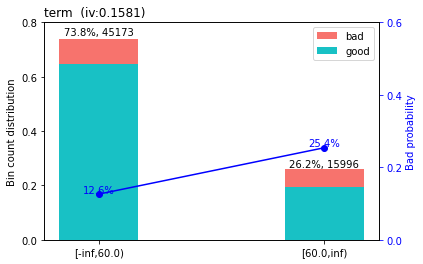

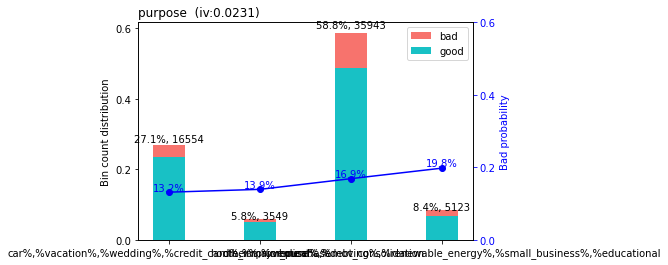

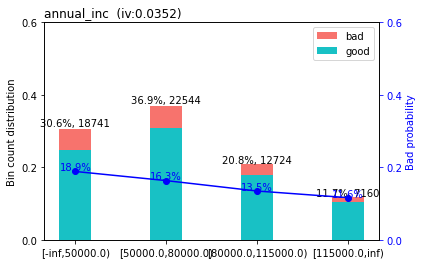

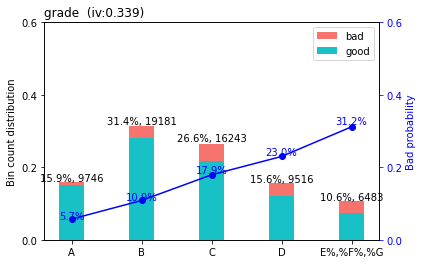

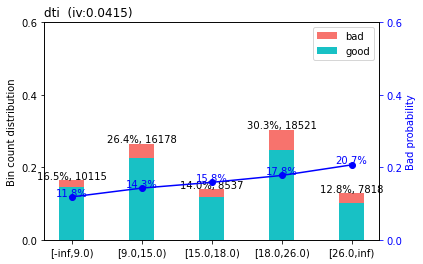

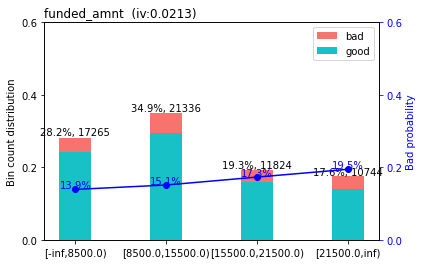

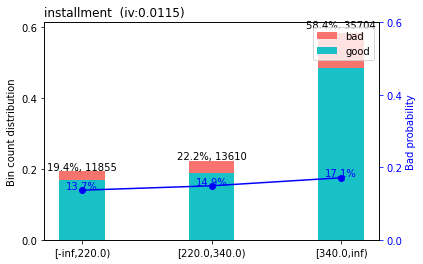

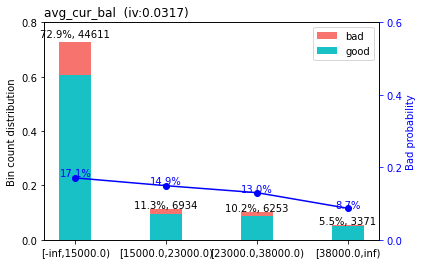

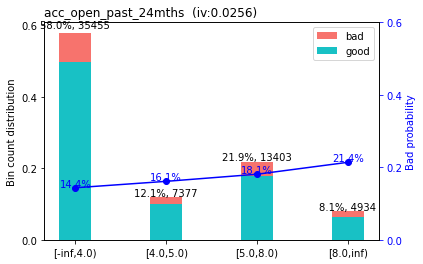

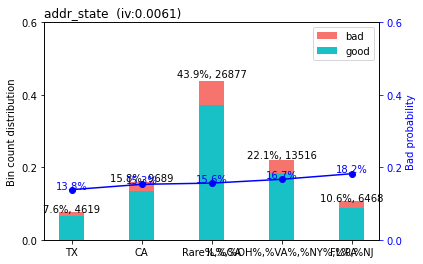

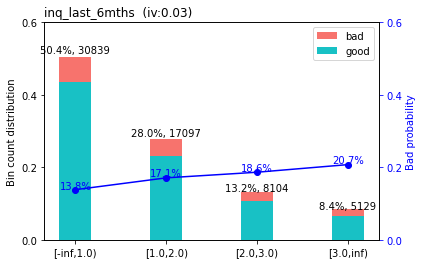

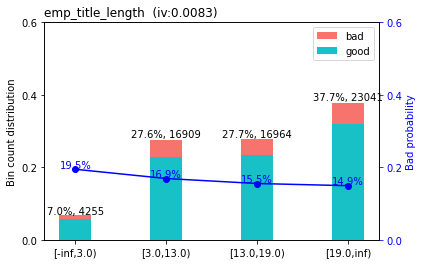

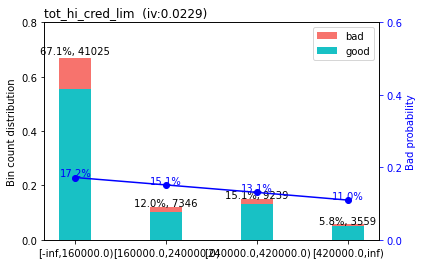

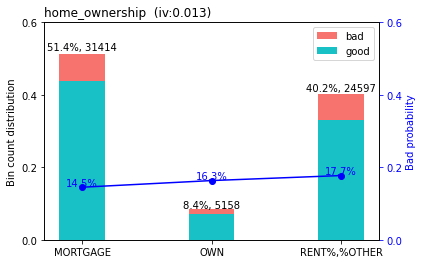

In [46]:
sc.woebin_plot(bins)

In [47]:
bins_adj = sc.woebin(tr_woe, y="def", positive = 'def|0')

[INFO] creating woe binning ...


In [48]:
tr_newwoe = sc.woebin_ply(tr_new, bins_adj)
test_newwoe = sc.woebin_ply(test_new, bins_adj)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


Оставим колонку funded_amnt и installment для будущего расчета ожидаемой прибыли

In [49]:
tr_newwoe['funded_amnt'] = tr_woe['funded_amnt']
tr_newwoe['installment'] = tr_woe['installment']
tr_newwoe['term'] = tr_woe['term']

test_newwoe['funded_amnt'] = test_woe['funded_amnt']
test_newwoe['installment'] = test_woe['installment']
test_newwoe['term'] = test_woe['term']

Теперь мы заменили значения признаков на WOE, вычисленные ранее: заметим, что мы не стали удалять признаки, где iv < 0.02, поскольку из-за этого модель сильно теряла в качестве

# Логистическая регрессия

Сначала разделим выборку на тренировочную и валидационную (на ней мы будем позже смотреть наиболее подходящие значения трешхолда, подобранные через оптимальное соотношение accuracy и recall, а так же через максимизацию прибыли)

In [50]:
X_train = tr_newwoe.drop(columns = 'def')
y_train = tr_newwoe['def']
X_test = test_newwoe.drop(columns = 'def')
y_test = test_newwoe['def']

In [51]:
funded_amnt = X_test['funded_amnt']
installment = X_test['installment']
term = X_test['term']

X_train = X_train.drop(columns = ['funded_amnt', 'installment', 'term', 'delinq_amnt'])
X_test = X_test.drop(columns = ['funded_amnt', 'installment', 'term', 'delinq_amnt'])

Теперь подберем гиперпараметры логистической регрессии через Grid Search + Cross Validation

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

params = {'C' : np.logspace(start = -3, stop = 0, num = 10),
          'penalty' : ['l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'saga', 'lbfgs']}

skf = StratifiedKFold(n_splits=10)

lr = LogisticRegression(random_state = 42)
grid_lr = GridSearchCV(lr, params, cv = skf, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

preds = grid_lr.predict_proba(X_test)
print("Значение ROC AUC test: ", roc_auc_score(y_test, preds[:, 1]))
print("Коэффициент Джини test:", roc_auc_score(y_test, preds[:, 1]) * 2 - 1)

Значение ROC AUC test:  0.6824569571721424
Коэффициент Джини test: 0.3649139143442848


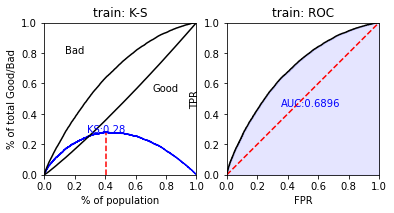

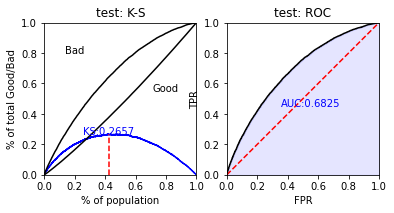

In [53]:
train_pred = grid_lr.predict_proba(X_train)[:,1]
test_pred = grid_lr.predict_proba(X_test)[:,1]
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

Узнаем про параметры:

In [54]:
print(grid_lr.best_params_)

{'C': 0.46415888336127775, 'penalty': 'l2', 'solver': 'lbfgs'}


Проделаем аналогичные действия, но теперь будем использовать Randomized Search, чтобы сравнить результаты

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

params = {'C' : np.logspace(start = -3, stop = 0, num = 10),
          'penalty' : ['l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'saga', 'lbfgs']}

skf = StratifiedKFold(n_splits=10)

lr = LogisticRegression(random_state = 42)
random_lr = RandomizedSearchCV(lr, params, cv = skf, scoring='roc_auc', random_state = 42)
random_lr.fit(X_train, y_train)

preds = random_lr.predict_proba(X_test)
print("Значение ROC AUC test: ", roc_auc_score(y_test, preds[:, 1]))
print("Коэффициент Джини test:", roc_auc_score(y_test, preds[:, 1]) * 2 - 1)

Значение ROC AUC test:  0.6824307653621848
Коэффициент Джини test: 0.36486153072436966


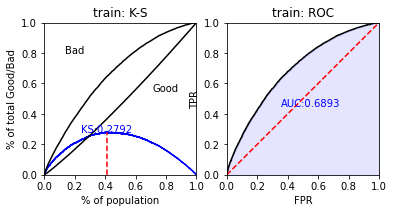

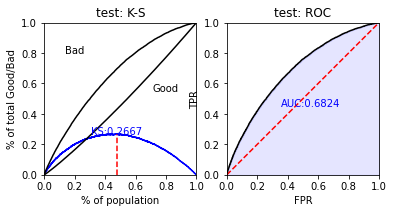

In [56]:
train_pred = random_lr.predict_proba(X_train)[:,1]
test_pred = random_lr.predict_proba(X_test)[:,1]

train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [57]:
print(random_lr.best_params_)

{'solver': 'saga', 'penalty': 'l1', 'C': 0.1}


Видим, что оптимальные параметры сильно изменились, однако значения ROC AUC и коэффициента упали незначительно

Теперь попробуем выбрать трешхолд, чтобы учитывать такую метрику как полнота, так как нам лучше не выдать кредит надежному заемщику, чем выдать кредит ненадежному. Будем использовать оптимальные параметры, найденные при помощи GridSearchCV

In [58]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
preds = grid_lr.predict_proba(X_test)
precision = []
recall = []
accuracy = []
f1 = []
x = [1 * i / 100 for i in range(51)]
for i in range(51):
    threshold = 1 * i / 100
    preds_change = ((preds[:, 1]) > threshold).astype(int)
    precision.append(precision_score(y_test, preds_change))
    recall.append(recall_score(y_test, preds_change))
    accuracy.append(accuracy_score(y_test, preds_change))
    f1.append(f1_score(y_test, preds_change))
    
precision = pd.DataFrame({'threshold' : x, 'score' : precision})
precision['metric'] = 'precision'
recall = pd.DataFrame({'threshold' : x, 'score' : recall})
recall['metric'] = 'recall'
accuracy = pd.DataFrame({'threshold' : x, 'score' : accuracy})
accuracy['metric'] = 'accuracy'
f1 = pd.DataFrame({'threshold' : x, 'score' : f1})
f1['metric'] = 'f1'

df = pd.concat([precision, recall, accuracy, f1])
fig = px.line(df, x='threshold', y='score', color='metric', markers=True)
fig.show()

In [59]:
lr_woe = LogisticRegression(C = 0.46415888336127775, penalty = 'l2', solver = 'lbfgs', random_state = 42)
lr_woe.fit(X_train, y_train)
lr_preds = lr_woe.predict_proba(X_test)
print("Значение ROC AUC: ", roc_auc_score(y_test, (lr_preds[:, 1] >= 0.17).astype(int)))
print("Коэффициент Джини:", roc_auc_score(y_test, (lr_preds[:, 1] >= 0.17).astype(int)) * 2 - 1)

Значение ROC AUC:  0.6319583054782589
Коэффициент Джини: 0.26391661095651786


# Расчет ожидаемой прибыли от кредитования

Попробуем подобрать трешхолд, руководствуясь результатами расчета ожидаемой прибыли от кредитования на отложенной выборке X_test, y_test (настоящие тесты находятся в другом файле):

In [60]:
best_profit = -1e9
best_threshold = -1
X_test['funded_amnt'] = funded_amnt
X_test['installment'] = installment
X_test['term'] = term
X_test['def'] = y_test

thresholds = [i for i in range(1, 100)]
profits = []

for i in range(1, 100):
    threshold = i / 100
    X_test['preds'] = (lr_preds[:, 1] >= threshold).astype(int)
    
    # дали, кому надо
    # 3 года
    X_test.loc[X_test[(X_test['def'] == X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 36)].index, 'profit'] = 0.13 * (3 * X_test['funded_amnt'] - (12 + 2 * 12) * X_test['installment'])
    # 5 лет
    X_test.loc[X_test[(X_test['def'] == X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 60)].index, 'profit'] = 0.13 * (5 * X_test['funded_amnt'] - (12 + 2 * 12 + 3 * 12 + 4 * 12) * X_test['installment'])
    
    # не дали, кому не надо
    X_test.loc[X_test[(X_test['def'] == X_test['preds']) & (X_test['def'] == 1)].index, 'profit'] = 0
    
    # дали, кому не надо -> потеряли funded_amnt
    X_test.loc[X_test[(X_test['def'] != X_test['preds']) & (X_test['def'] == 1)].index, 'profit'] = -1 * X_test['funded_amnt']
    
    # не дали, а можно было бы: потеряли ожидаемую прибыль
    X_test.loc[X_test[(X_test['def'] != X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 36)].index, 'profit'] = -0.13 * (3 * X_test['funded_amnt'] - (12 + 2 * 12) * X_test['installment'])
    X_test.loc[X_test[(X_test['def'] != X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 60)].index, 'profit'] = -0.13 * (5 * X_test['funded_amnt'] - (12 + 2 * 12 + 3 * 12 + 4 * 12) * X_test['installment'])
    
    profit = X_test['profit'].sum()
    profits.append(profit)
    
    if profit > best_profit:
        best_profit = profit
        best_threshold = threshold

profits = pd.DataFrame({'threshold' : thresholds, 'profit' : profits})
fig = px.line(profits, x='threshold', y='profit', markers=True)
fig.update_layout(title = "Profit values for different thresholds. LGD = 1")
fig.show()
print("Лучший порог отсечения:", best_threshold)
print("Макс.ожидаемая прибыль:", best_profit)

Лучший порог отсечения: 0.35
Макс.ожидаемая прибыль: 28994395.560800005


Мы подобрали оптимальный трешхолд для выдачи кредита при расчете ожидаемой прибыли от кредитования, если при дефолте клиента мы теряем всю сумму funded_amnt. Видим, что на самом деле нет нужды так сильно сокращать трешхолд и добиваться высокого значения recall, если наша цель – максимизировать прибыль

Если же мы будем терять лишь 80% от выданной суммы:

In [61]:
best_profit = -1e9
best_threshold = -1
X_test['funded_amnt'] = funded_amnt
X_test['installment'] = installment
X_test['term'] = term
X_test['def'] = y_test

thresholds = [i for i in range(1, 100)]
profits = []

for i in range(1, 100):
    threshold = i / 100
    X_test['preds'] = (lr_preds[:, 1] >= threshold).astype(int)
    
    # дали, кому надо
    # 3 года
    X_test.loc[X_test[(X_test['def'] == X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 36)].index, 'profit'] = 0.13 * (3 * X_test['funded_amnt'] - (12 + 2 * 12) * X_test['installment'])
    # 5 лет
    X_test.loc[X_test[(X_test['def'] == X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 60)].index, 'profit'] = 0.13 * (5 * X_test['funded_amnt'] - (12 + 2 * 12 + 3 * 12 + 4 * 12) * X_test['installment'])
    
    # не дали, кому не надо
    X_test.loc[X_test[(X_test['def'] == X_test['preds']) & (X_test['def'] == 1)].index, 'profit'] = 0
    
    # дали, кому не надо -> потеряли 0.8 * funded_amnt
    X_test.loc[X_test[(X_test['def'] != X_test['preds']) & (X_test['def'] == 1)].index, 'profit'] = -0.8 * X_test['funded_amnt']
    
    # не дали, а можно было бы: потеряли ожидаемую прибыль
    X_test.loc[X_test[(X_test['def'] != X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 36)].index, 'profit'] = -0.13 * (3 * X_test['funded_amnt'] - (12 + 2 * 12) * X_test['installment'])
    X_test.loc[X_test[(X_test['def'] != X_test['preds']) & (X_test['def'] == 0) & (X_test['term'] == 60)].index, 'profit'] = -0.13 * (5 * X_test['funded_amnt'] - (12 + 2 * 12 + 3 * 12 + 4 * 12) * X_test['installment'])
    
    profit = X_test['profit'].sum()
    profits.append(profit)
    
    if profit > best_profit:
        best_profit = profit
        best_threshold = threshold

profits = pd.DataFrame({'threshold' : thresholds, 'profit' : profits})
fig = px.line(profits, x='threshold', y='profit', markers=True)
fig.update_layout(title = "Profit values for different thresholds. LGD = 0.8")
fig.show()
print("Лучший порог отсечения:", best_threshold)
print("Макс.ожидаемая прибыль:", best_profit)

Лучший порог отсечения: 0.39
Макс.ожидаемая прибыль: 57534642.17440001


Видим, что порог отсечения поменялся в большую сторону (что логично, так как теперь выдача кредита менее надежному заемщику несет меньшие убытки, ведь LGD = 0.8). Увеличилась и прибыль – интересно, что увеличение произошло почти в 2 раза

# Обучение других моделей

Теперь посмотрим на результаты других моделей: градиентного бустинга и еще одного ансамбля, объединяющего в себе результаты градиентного бустинга и логистической регрессии с WOE-преобразованиями.

Просто для сравнения: обычная лог регрессия

In [62]:
tr_base = pd.get_dummies(tr, columns=['purpose', 'addr_state', 'grade', 'home_ownership', 'term'], drop_first = True)

In [63]:
tr_new = tr_base.loc['train']
test_new = tr_base.loc['test']

X_train = tr_new.drop(columns = 'def')
y_train = tr_new['def']
X_test = test_new.drop(columns = 'def')
y_test = test_new['def']

Не забудем стандартизировать наши признаки

In [67]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train = pd.DataFrame(ss.transform(X_train), columns = X_train.columns)
ss.fit(X_test)
X_test = pd.DataFrame(ss.transform(X_test), columns = X_test.columns)

Оценка ROC AUC через predict_proba...

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
preds = lr.predict_proba(X_test)
print(roc_auc_score(y_test, preds[:, 1]))

0.6837441943800858


Теперь подготовим данные для градиентного бустинга

In [69]:
tr_base = pd.get_dummies(tr, columns=['purpose', 'addr_state', 'grade', 'home_ownership', 'term'])
tr_new = tr_base.loc['train']
test_new = tr_base.loc['test']

X_train = tr_new.drop(columns = 'def')
y_train = tr_new['def']
X_test = test_new.drop(columns = 'def')
y_test = test_new['def']

Посмотрим на результаты градиентного бустинга

In [70]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

params = {'learning_rate': [i / 100 for i in range(5, 31, 5)],
            'max_depth': [2, 3, 4, 5],
            'min_child_weight': [10,15,20,25],
            'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
            'n_estimators': [50, 100, 150, 200, 250, 300],
            "reg_alpha"   : [0.5,0.75,1],
            "reg_lambda"  : [2,3,5]}

xgbc = xgb.XGBClassifier(random_state = 42)
skf = StratifiedKFold(n_splits=10)
grid_obj_xgbc = RandomizedSearchCV(xgbc, params, cv=skf, n_iter=10, scoring='roc_auc', n_jobs=12, random_state = 42)
grid_obj_xgbc.fit(X_train, y_train)

preds = grid_obj_xgbc.predict_proba(X_train)
boost_preds = grid_obj_xgbc.predict_proba(X_test)
print(roc_auc_score(y_train, preds[:, 1]))
print(roc_auc_score(y_test, boost_preds[:, 1]))

0.7074918064624786
0.685806713505422


In [71]:
print(grid_obj_xgbc.best_params_)

{'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [72]:
params = {'learning_rate': [0.1],
            'max_depth': [2],
            'min_child_weight': [10],
            'colsample_bytree': [0.7],
            'n_estimators': [300],
            "reg_alpha"   : [1],
            "reg_lambda"  : [3]}

xgbc = xgb.XGBClassifier(random_state = 42)
skf = StratifiedKFold(n_splits=10)
grid_obj_xgbc = RandomizedSearchCV(xgbc, params, cv=skf, n_iter=10, scoring='roc_auc', n_jobs=12, random_state = 42)
grid_obj_xgbc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impo...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=12,
                   param_distributions={'colsample_bytree': [0.7],
                                        'learning_rate': [0.1],
                                        'max_depth': [2],
                                        'min_child_weight': [10],
                                        'n_estimators': [300], 'reg_alpha': [1],
                                        'reg_lambda': [3]},
                   random_state=42, scoring='roc_auc')

Отлично, у нас получилось не переобучиться! Теперь попробуем построить кастомный ансамбль

In [73]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

woe_cols = tr_newwoe.drop(columns = ['def', 'funded_amnt', 'installment', 'term', 'delinq_amnt']).columns
pipe_woe = Pipeline([('select', ColumnTransformer([('woe', 'passthrough', woe_cols)], remainder='drop')), ('woe_lr', lr_woe)])

boosting_cols = X_train.columns
pipe_boosting = Pipeline([('select', ColumnTransformer([('boost', 'passthrough', boosting_cols)], remainder='drop')), ('gb', grid_obj_xgbc)])


X_train = pd.concat([X_train, tr_newwoe.drop(columns = ['def', 'funded_amnt', 'installment', 'term', 'num_accts_ever_120_pd', 'delinq_2yrs', 'delinq_amnt',
       'chargeoff_within_12_mths', 'employment_known', 'num_tl_90g_dpd_24m'])], axis=1)
X_test = pd.concat([X_test, test_newwoe.drop(columns = ['def', 'funded_amnt', 'installment', 'term', 'num_accts_ever_120_pd', 'delinq_2yrs', 'delinq_amnt',
       'chargeoff_within_12_mths', 'employment_known', 'num_tl_90g_dpd_24m'])], axis=1)

stacking_model = StackingClassifier(estimators = [('woe_lr', pipe_woe), ('gb', pipe_boosting)], cv = skf)
stacking_model.fit(X_train, y_train)
preds = stacking_model.predict_proba(X_test)
print(roc_auc_score(y_test, preds[:, 1]))

0.6856552751111475


Все-таки даже так результат почти не изменился по сравнению с woe-регрессией и градиентным бустингом

# Валидационные тесты

Теперь проведем валидационные тесты на двух моделях: woe-регрессии, которая была основным заданием, а также градиентном бустинге, который показал наилучший результат среди всех обученных моделей

### Эффективность ранжирования всей модели

In [74]:
from sklearn.metrics import roc_curve, auc

def rocauc_gini(y_test, preds):
    
    print("Значение ROC AUC: ", roc_auc_score(y_test, preds[:, 1]))
    print("Коэффициент Джини:", roc_auc_score(y_test, preds[:, 1]) * 2 - 1)
    
    fpr, tpr, thresholds = roc_curve(y_test, preds[:, 1])

    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=500, height=500, color_discrete_sequence = ['#9467BD']
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.update_traces(marker_color='#9467BD')
    fig.show()

In [75]:
rocauc_gini(y_test, lr_preds)

Значение ROC AUC:  0.6824569571721424
Коэффициент Джини: 0.3649139143442848


In [76]:
rocauc_gini(y_test, boost_preds)

Значение ROC AUC:  0.685806713505422
Коэффициент Джини: 0.371613427010844


### Эффективность ранжирования всех факторов

In [77]:
def feature_gini(X_train, y_train, X_test, y_test, model):
    
    ginis = {'feature': [], 'gini': []}
    for x in X_train.columns:
        trainx = pd.DataFrame(X_train[x])
        testx = pd.DataFrame(X_test[x])
        
        model.fit(trainx, y_train)
        preds = model.predict_proba(testx)
        ginis['feature'].append(x)
        ginis['gini'].append(roc_auc_score(y_test, preds[:, 1]) * 2 - 1)
    
    df = pd.DataFrame(ginis)
    df = df.sort_values(by='gini', ascending=False)
    print('Red factors:   ', len(df[df['gini'] < 0]) / len(df))
    print('Yellow factors:', len(df[(df['gini'] <= 0.05) & (df['gini'] >= 0)]) / len(df))
    print('Green factors: ', len(df[df['gini'] > 0.05]) / len(df))
    
    fig = px.bar(df, x='feature', y='gini', title='Gini by features')
    fig.update_traces(marker_color='#9467BD')
    fig.show()

In [78]:
X_train = tr_newwoe.drop(columns = ['funded_amnt', 'installment', 'term', 'def', 'delinq_amnt'])
y_train = tr_newwoe['def']
X_test = test_newwoe.drop(columns = ['funded_amnt', 'installment', 'term', 'def', 'delinq_amnt'])
y_test = test_newwoe['def']
feature_gini(X_train, y_train, X_test, y_test, lr_woe)

Red factors:    0.0
Yellow factors: 0.42105263157894735
Green factors:  0.5789473684210527


In [79]:
X_train = tr_base.loc['train'].drop(columns = 'def')
y_train = tr_base.loc['train']['def']
X_test = tr_base.loc['test'].drop(columns = 'def')
y_test = tr_base.loc['test']['def']
feature_gini(X_train, y_train, X_test, y_test, grid_obj_xgbc)

Red factors:    0.14035087719298245
Yellow factors: 0.5614035087719298
Green factors:  0.2982456140350877


### Анализ корректности дискретного преобразования факторов

Применимо только к woe-регрессии

{'term': <Figure size 432x288 with 2 Axes>,
 'purpose': <Figure size 432x288 with 2 Axes>,
 'annual_inc': <Figure size 432x288 with 2 Axes>,
 'grade': <Figure size 432x288 with 2 Axes>,
 'dti': <Figure size 432x288 with 2 Axes>,
 'funded_amnt': <Figure size 432x288 with 2 Axes>,
 'installment': <Figure size 432x288 with 2 Axes>,
 'avg_cur_bal': <Figure size 432x288 with 2 Axes>,
 'acc_open_past_24mths': <Figure size 432x288 with 2 Axes>,
 'addr_state': <Figure size 432x288 with 2 Axes>,
 'inq_last_6mths': <Figure size 432x288 with 2 Axes>,
 'emp_title_length': <Figure size 432x288 with 2 Axes>,
 'tot_hi_cred_lim': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>}

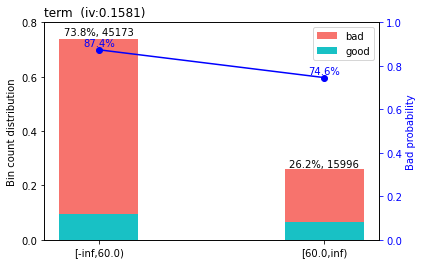

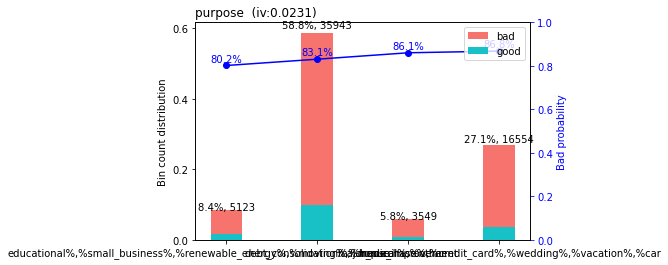

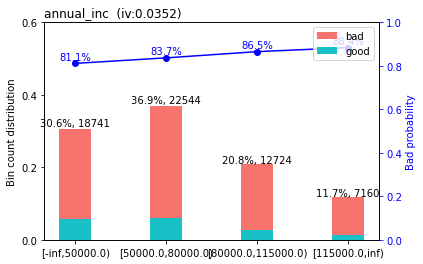

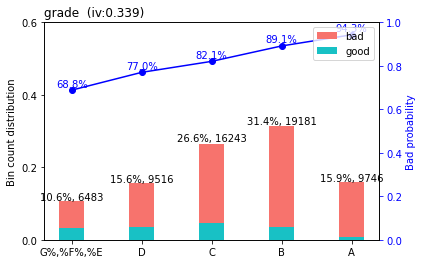

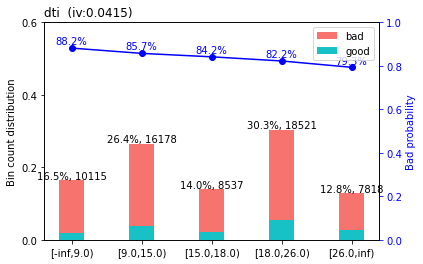

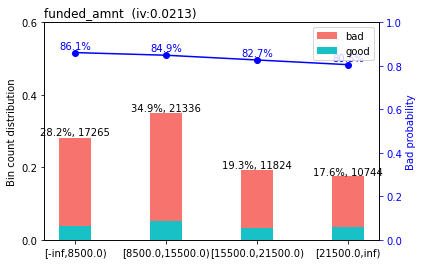

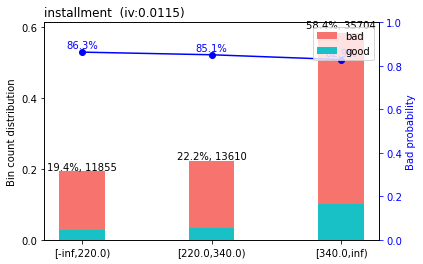

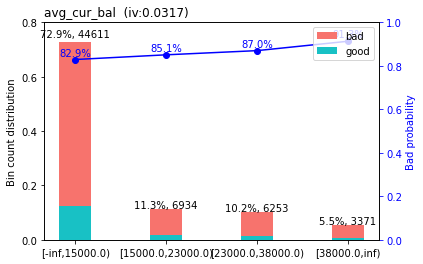

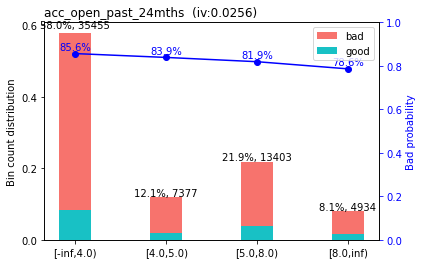

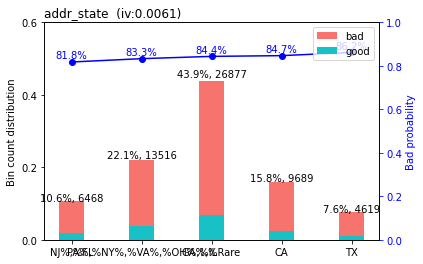

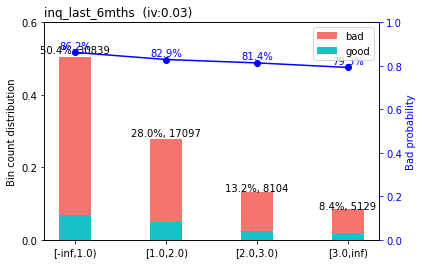

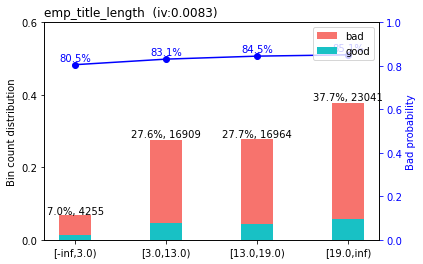

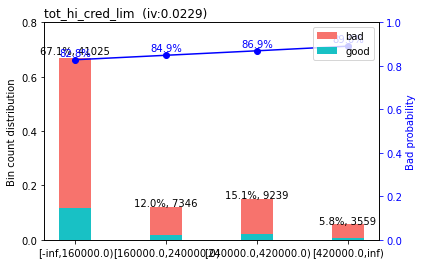

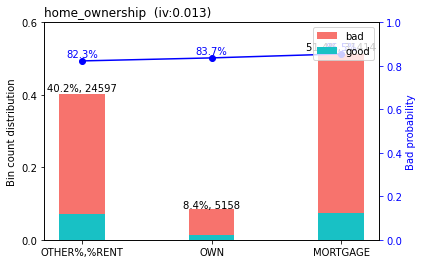

In [80]:
sc.woebin_plot(bins_adj)

### Сравнение эффективности ранжирования модели на разработке и валидации

In [81]:
def rocauc_gini_train_test(X_train, y_train, X_test, y_test, model):
    
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_train)
    preds2 = model.predict_proba(X_test)
    ginis = {'gini': [roc_auc_score(y_train, preds[:, 1]) * 2 - 1, roc_auc_score(y_test, preds2[:, 1]) * 2 - 1],
            'train_test': ['train', 'test']}
    
    print("Абсолютное изменение:   ", ginis['gini'][1] - ginis['gini'][0])
    print("Относительное изменение:", (ginis['gini'][1] - ginis['gini'][0]) / ginis['gini'][0])
    
    ginis = pd.DataFrame(ginis)
    fig = px.bar(ginis, x="train_test", y="gini", title='Gini by features: train & test')
    fig.update_traces(marker_color='#9467BD')
    fig.show()

In [82]:
X_train = tr_newwoe.drop(columns = ['funded_amnt', 'installment', 'term', 'def', 'delinq_amnt'])
y_train = tr_newwoe['def']
X_test = test_newwoe.drop(columns = ['funded_amnt', 'installment', 'term', 'def', 'delinq_amnt'])
y_test = test_newwoe['def']
rocauc_gini_train_test(X_train, y_train, X_test, y_test, lr_woe)

Абсолютное изменение:    -0.01432286304723207
Относительное изменение: -0.037767600351812446


In [83]:
X_train = tr_base.loc['train'].drop(columns = 'def')
y_train = tr_base.loc['train']['def']
X_test = tr_base.loc['test'].drop(columns = 'def')
y_test = tr_base.loc['test']['def']
rocauc_gini_train_test(X_train, y_train, X_test, y_test, grid_obj_xgbc)

Абсолютное изменение:    -0.043370185914113124
Относительное изменение: -0.10451059888467427


### Сравнение эффективности ранжирования отдельных факторов модели на разработке и валидации

In [84]:
def feature_gini_train_test(X_train, y_train, X_test, y_test, model):
    
    ginis = {'feature': [], 'gini': [], 'train_test': []}
    gini_change = []
    for x in X_train.columns:
        trainx = pd.DataFrame(X_train[x])
        testx = pd.DataFrame(X_test[x])
        
        model.fit(trainx, y_train)
        
        preds2 = model.predict_proba(trainx)
        ginis['feature'].append(x)
        ginis['gini'].append(roc_auc_score(y_train, preds2[:, 1]) * 2 - 1)
        ginis['train_test'].append('train')
        
        preds = model.predict_proba(testx)
        ginis['feature'].append(x)
        ginis['gini'].append(roc_auc_score(y_test, preds[:, 1]) * 2 - 1)
        ginis['train_test'].append('test')
        
        gini_change.append((x, (roc_auc_score(y_test, preds[:, 1]) * 2 - 1) - (roc_auc_score(y_train, preds2[:, 1]) * 2 - 1), ((roc_auc_score(y_test, preds[:, 1]) * 2 - 1) - (roc_auc_score(y_train, preds2[:, 1]) * 2 - 1)) / (roc_auc_score(y_train, preds2[:, 1]) * 2 - 1)))
    
    for x in gini_change:
        print(x[0], ': абс. сниж. = ', round(x[1], 3), ', относ. сниж. = ', round(x[2], 3), sep='')
    
    df = pd.DataFrame(ginis)
    fig = px.bar(df, x="feature", y="gini", color='train_test', barmode='group', color_discrete_map={'train': '#9467BD', 'test': '#FECB52'}, title='Gini by features: train & test')
    fig.show()

In [85]:
X_train = tr_newwoe.drop(columns = ['funded_amnt', 'installment', 'term', 'def', 'delinq_amnt'])
y_train = tr_newwoe['def']
X_test = test_newwoe.drop(columns = ['funded_amnt', 'installment', 'term', 'def'])
y_test = test_newwoe['def']
feature_gini_train_test(X_train, y_train, X_test, y_test, lr_woe)

chargeoff_within_12_mths: абс. сниж. = -0.001, относ. сниж. = -0.332
num_accts_ever_120_pd: абс. сниж. = 0.007, относ. сниж. = 0.509
employment_known: абс. сниж. = 0.005, относ. сниж. = 0.312
num_tl_90g_dpd_24m: абс. сниж. = -0.0, относ. сниж. = -0.025
delinq_2yrs: абс. сниж. = -0.006, относ. сниж. = -0.464
purpose_woe: абс. сниж. = -0.017, относ. сниж. = -0.217
annual_inc_woe: абс. сниж. = 0.006, относ. сниж. = 0.058
term_woe: абс. сниж. = -0.059, относ. сниж. = -0.321
grade_woe: абс. сниж. = 0.017, относ. сниж. = 0.054
dti_woe: абс. сниж. = 0.032, относ. сниж. = 0.285
funded_amnt_woe: абс. сниж. = -0.039, относ. сниж. = -0.494
installment_woe: абс. сниж. = -0.01, относ. сниж. = -0.178
avg_cur_bal_woe: абс. сниж. = 0.029, относ. сниж. = 0.432
acc_open_past_24mths_woe: абс. сниж. = 0.07, относ. сниж. = 0.859
addr_state_woe: абс. сниж. = -0.031, относ. сниж. = -0.78
inq_last_6mths_woe: абс. сниж. = -0.002, относ. сниж. = -0.023
emp_title_length_woe: абс. сниж. = 0.013, относ. сниж. = 0.

In [86]:
X_train = tr_base.loc['train'].drop(columns = 'def')
y_train = tr_base.loc['train']['def']
X_test = tr_base.loc['test'].drop(columns = 'def')
y_test = tr_base.loc['test']['def']
feature_gini_train_test(X_train, y_train, X_test, y_test, grid_obj_xgbc)

installment: абс. сниж. = -0.082, относ. сниж. = -0.62
dti: абс. сниж. = 0.006, относ. сниж. = 0.045
funded_amnt: абс. сниж. = -0.065, относ. сниж. = -0.522
annual_inc: абс. сниж. = -0.021, относ. сниж. = -0.166
emp_length: абс. сниж. = 0.011, относ. сниж. = 0.388
inq_last_6mths: абс. сниж. = -0.003, относ. сниж. = -0.028
mths_since_recent_inq: абс. сниж. = 0.004, относ. сниж. = 0.05
delinq_2yrs: абс. сниж. = -0.006, относ. сниж. = -0.464
chargeoff_within_12_mths: абс. сниж. = -0.001, относ. сниж. = -0.332
num_accts_ever_120_pd: абс. сниж. = 0.007, относ. сниж. = 0.509
num_tl_90g_dpd_24m: абс. сниж. = -0.0, относ. сниж. = -0.025
acc_open_past_24mths: абс. сниж. = 0.057, относ. сниж. = 0.582
avg_cur_bal: абс. сниж. = -0.011, относ. сниж. = -0.094
tot_hi_cred_lim: абс. сниж. = -0.013, относ. сниж. = -0.118
delinq_amnt: абс. сниж. = 0.0, относ. сниж. = 0.645
employment_known: абс. сниж. = 0.005, относ. сниж. = 0.312
emp_title_length: абс. сниж. = -0.011, относ. сниж. = -0.193
issue_year: 